<h1> <b>Sistem Rekomendasi Film<b> <h1> 

# Import Library

Mengimpor library yang dibutuhkan


In [1]:
import pandas as pd
import numpy as np
import zipfile
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

# Data Loading

Mengunduh data dari https://www.kaggle.com/datasets/bandikarthik/movie-recommendation-system Dataset kemudian diunggah ke *google drive*, lalu untuk memuat data di Google Collab menggunakan Mounted drive.

Dataset ini terdiri dari beberapa dataset berikut:

* links : daftar link film.
* movies : daftar film.
* ratings : daftar penilaian yang diberikan pengguna terhadap film.
* tags : daftar kata kunci dari film tersebut


In [2]:
# Mounted drive untuk menyambungkan file drive dengan sheet colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Mengekstrak dataset
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Colab_Notebooks/Movie_Recomendation.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [4]:
# Membuat dataframe 
links = pd.read_csv('/tmp/links.csv')
movies = pd.read_csv('/tmp/movies.csv')
ratings = pd.read_csv('/tmp/ratings.csv')
tags = pd.read_csv('/tmp/tags.csv')

# Explanatory Data Analysis

Melakukan beberapa tahapan sebagai berikut : 

1.   Deskripsi dataset
2.   Deskripsi variabel pada dataset


##Deskripsi Dataset **links**

In [5]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34208 entries, 0 to 34207
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  34208 non-null  int64  
 1   imdbId   34208 non-null  int64  
 2   tmdbId   33912 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 801.9 KB


Dataset terdiri dari:

*   34208 data dalam links
*   2 buah kolom bertipe int64 yaitu movieId dan imdbId 
*   1 buah kolom bertipe float64 yaitu tmdbId 



## Deskripsi Dataset **movies**

In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34208 entries, 0 to 34207
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  34208 non-null  int64 
 1   title    34208 non-null  object
 2   genres   34208 non-null  object
dtypes: int64(1), object(2)
memory usage: 801.9+ KB


Dataset terdiri dari:

*   34208 data dalam links
*   1 buah kolom bertipe int64 yaitu movieId
*   2 buah kolom bertipe object yaitu title dan genres 



In [7]:
print('Jumlah data movies : ', len(movies.movieId.unique()))
print('Jumlah judul film: ', len(movies.title.unique()))
print('Jumlah genre film: ', len(movies.genres.unique()))

Jumlah data movies :  34208
Jumlah judul film:  34185
Jumlah genre film:  1446


## Deskripsi dataset **ratings**

In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22884377 entries, 0 to 22884376
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 698.4 MB


Dataset terdiri dari:

*   22884377 data dalam links
*   3 buah kolom bertipe int64 yaitu userId, movieId dan timestamp
*   1 buah kolom bertipe float64 yaitu rating

Karena data terlalu banyak, maka data yang akan digunakan hanya 10000 data saja

In [9]:
# Memuat dataset rating sebanyak 10000 record data
ratings = ratings.iloc[:10000,:]

In [10]:
# Cek ukuran dataset 
ratings.shape

(10000, 4)

In [11]:
print('Jumlah data ratings dari user : ', len(ratings.userId.unique()))
print('Jumlah data ratings dari movie : ', len(ratings.movieId.unique()))

Jumlah data ratings dari user :  106
Jumlah data ratings dari movie :  3466


In [12]:
ratings.describe()

,userId,movieId,rating,timestamp
count,10000.000000,10000.0000,10000.000000,1.000000e+04
mean,49.805200,10429.1596,3.460650,1.130739e+09
std,30.826058,21014.5552,1.170348,1.623057e+08
min,1.000000,1.0000,0.500000,8.345235e+08
25%,20.000000,1089.0000,3.000000,9.746870e+08
50%,45.000000,2398.0000,3.500000,1.137894e+09
75%,74.000000,5460.2500,4.000000,1.284972e+09
max,106.000000,141956.0000,5.000000,1.452383e+09


Dapat kita lihat dari nilai max dan min bahwa nilai rating terbesar yaitu 5, dan nilai rating terkecil yaitu 0.5

## Deskripsi dataset **tags**

In [13]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586994 entries, 0 to 586993
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   userId     586994 non-null  int64 
 1   movieId    586994 non-null  int64 
 2   tag        586978 non-null  object
 3   timestamp  586994 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 17.9+ MB


Dataset terdiri dari:

*   586994 data dalam links
*   3 buah kolom bertipe int64 yaitu userId, movieId dan timestamp
*   1 buah kolom bertipe object yaitu tag

Karena data terlalu banyak, maka data yang akan digunakan hanya 10000 data saja

In [14]:
# Memuat dataset rating sebanyak 10000 record data
tags = tags.iloc[:10000,:]

In [15]:
# Cek ukuran dataset 
tags.shape

(10000, 4)

In [16]:
print('Jumlah tag movie: ', len(tags.tag.unique()))

Jumlah tag movie:  2715


# Content Based Filtering

## Data Preprocessing



### Menggabungkan variable **movieId** di dataset movies

In [17]:
import numpy as np
 
# Menggabungkan seluruh movieId pada kategori movie
movie_all = np.concatenate((
    links.movieId.unique(),
    movies.movieId.unique(),
    ratings.movieId.unique(),
    tags.movieId.unique(),
))
 
# Mengurutkan data dan mengambil record data yang unik atau tidak duplikat
movie_all = np.sort(np.unique(movie_all))
 
print('Jumlah seluruh data movie berdasarkan movieID: ', len(movie_all))

Jumlah seluruh data movie berdasarkan movieID:  34208


### Menggabungkan variabel **userId** di dataset movies

In [18]:
# Menggabungkan seluruh userId
user_all = np.concatenate((
    ratings.userId.unique(),
    tags.userId.unique(),
   
))
 
# Mengurutkan data dan mengambil record data yang unik atau tidak duplikat
user_all = np.sort(np.unique(user_all)) 
 
print('Jumlah seluruh user: ', len(user_all))

Jumlah seluruh user:  506


### Membuat dataframe all_movie_rate

In [19]:
# Mendefinisikan dataframe all_movie_rate yang berisi rating
all_movie_rate = ratings
all_movie_rate

,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496
...,...,...,...,...
9995,106,69134,2.5,1296169876
9996,106,69275,1.5,1296169296
9997,106,69278,2.5,1296167968
9998,106,69436,0.5,1296167671


In [20]:
# Menggabungkan variabel userId, movieId, title, dan genres keseluruhan ke dalam dataframe all_movie_rate
all_movie_name = pd.merge(all_movie_rate, movies[['movieId','title','genres']], on='movieId', how='left')
all_movie_name

,userId,movieId,rating,timestamp,title,genres
0,1,169,2.5,1204927694,Free Willy 2: The Adventure Home (1995),Adventure|Children|Drama
1,1,2471,3.0,1204927438,Crocodile Dundee II (1988),Action|Adventure|Comedy
2,1,48516,5.0,1204927435,"Departed, The (2006)",Crime|Drama|Thriller
3,2,2571,3.5,1436165433,"Matrix, The (1999)",Action|Sci-Fi|Thriller
4,2,109487,4.0,1436165496,Interstellar (2014),Sci-Fi|IMAX
...,...,...,...,...,...,...
9995,106,69134,2.5,1296169876,Antichrist (2009),Drama|Fantasy
9996,106,69275,1.5,1296169296,Dead Snow (Død snø) (2009),Action|Adventure|Comedy|Horror
9997,106,69278,2.5,1296167968,Land of the Lost (2009),Action|Adventure|Comedy|Sci-Fi
9998,106,69436,0.5,1296167671,Year One (2009),Adventure|Comedy


In [21]:
# Menggabungkan variabel movieId, dan tag ke dalam dataframe all_movie_rate
all_movie = pd.merge(all_movie_name, tags[['movieId','tag']], on='movieId', how='left')
all_movie

,userId,movieId,rating,timestamp,title,genres,tag
0,1,169,2.5,1204927694,Free Willy 2: The Adventure Home (1995),Adventure|Children|Drama,family
1,1,2471,3.0,1204927438,Crocodile Dundee II (1988),Action|Adventure|Comedy,NaN
2,1,48516,5.0,1204927435,"Departed, The (2006)",Crime|Drama|Thriller,Crime
3,1,48516,5.0,1204927435,"Departed, The (2006)",Crime|Drama|Thriller,organized crime
4,1,48516,5.0,1204927435,"Departed, The (2006)",Crime|Drama|Thriller,psychology
...,...,...,...,...,...,...,...
72717,106,69134,2.5,1296169876,Antichrist (2009),Drama|Fantasy,Willem Dafoe
72718,106,69275,1.5,1296169296,Dead Snow (Død snø) (2009),Action|Adventure|Comedy|Horror,NaN
72719,106,69278,2.5,1296167968,Land of the Lost (2009),Action|Adventure|Comedy|Sci-Fi,NaN
72720,106,69436,0.5,1296167671,Year One (2009),Adventure|Comedy,NaN


## Data Preparation

### Menangani missing value

In [22]:
# cek missing value
all_movie.isnull().sum()

userId          0
movieId         0
rating          0
timestamp       0
title           0
genres          0
tag          3675
dtype: int64

Terdapat  3675 missing value terhadap fitur tag. Untuk menghindari bias, missing value tidak diisi dengan modus. Maka missing value akan di hapus menggunakan fungsi dropna

In [23]:
all_movie_clean = all_movie.dropna()
all_movie_clean

,userId,movieId,rating,timestamp,title,genres,tag
0,1,169,2.5,1204927694,Free Willy 2: The Adventure Home (1995),Adventure|Children|Drama,family
2,1,48516,5.0,1204927435,"Departed, The (2006)",Crime|Drama|Thriller,Crime
3,1,48516,5.0,1204927435,"Departed, The (2006)",Crime|Drama|Thriller,organized crime
4,1,48516,5.0,1204927435,"Departed, The (2006)",Crime|Drama|Thriller,psychology
5,1,48516,5.0,1204927435,"Departed, The (2006)",Crime|Drama|Thriller,suspense
...,...,...,...,...,...,...,...
72714,106,69134,2.5,1296169876,Antichrist (2009),Drama|Fantasy,Nudity (Full Frontal)
72715,106,69134,2.5,1296169876,Antichrist (2009),Drama|Fantasy,religion
72716,106,69134,2.5,1296169876,Antichrist (2009),Drama|Fantasy,weird
72717,106,69134,2.5,1296169876,Antichrist (2009),Drama|Fantasy,Willem Dafoe


In [24]:
# cek ulang missing value
all_movie_clean.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
tag          0
dtype: int64

Missing value sudah tidak ada

### Mengurutkan Data

Mengurutkan data secara ascending

In [25]:
# Mengurutkan film berdasarkan movieId ke dalam variabel fix_movie
fix_movie = all_movie_clean.sort_values('movieId', ascending=True)
fix_movie

,userId,movieId,rating,timestamp,title,genres,tag
43037,56,1,3.0,861786289,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,children
30901,40,1,4.0,869044457,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Disney
30900,40,1,4.0,869044457,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Pixar
30899,40,1,4.0,869044457,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Disney
30898,40,1,4.0,869044457,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,comedy
...,...,...,...,...,...,...,...
2440,7,134853,5.0,1451817861,Inside Out (2015),Animation|Children|Comedy,Pixar
2439,7,134853,5.0,1451817861,Inside Out (2015),Animation|Children|Comedy,coming of age
15893,22,134853,5.0,1447601019,Inside Out (2015),Animation|Children|Comedy,Pixar
50151,63,138610,1.5,1445125000,"Gallows, The (2015)",Horror,found footage


In [26]:
# Mengecek jumlah record data fix movie
len(fix_movie.movieId.unique())

1442

In [27]:
# Membuat variabel preparation yang berisi dataframe fix_movie kemudian mengurutkan berdasarkan movieId
preparation = fix_movie
preparation.sort_values('movieId', ascending=True)

,userId,movieId,rating,timestamp,title,genres,tag
43037,56,1,3.0,861786289,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,children
43762,58,1,4.0,952806763,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,animation
43763,58,1,4.0,952806763,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,children
43764,58,1,4.0,952806763,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,toys
43765,58,1,4.0,952806763,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,itaege
...,...,...,...,...,...,...,...
2440,7,134853,5.0,1451817861,Inside Out (2015),Animation|Children|Comedy,Pixar
2439,7,134853,5.0,1451817861,Inside Out (2015),Animation|Children|Comedy,coming of age
15893,22,134853,5.0,1447601019,Inside Out (2015),Animation|Children|Comedy,Pixar
50151,63,138610,1.5,1445125000,"Gallows, The (2015)",Horror,found footage


### Menangani data duplikat

Menghapus data yang duplikat dengan fungsi drop_duplicates(). Dalam hal ini, membuang data duplikat pada kolom ‘movieId’.

In [28]:
# Menghapus data duplikat pada variabel preparation
preparation = preparation.drop_duplicates('movieId')
preparation

,userId,movieId,rating,timestamp,title,genres,tag
43037,56,1,3.0,861786289,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,children
3492,13,2,2.0,974867742,Jumanji (1995),Adventure|Children|Fantasy,fantasy
60870,92,6,3.0,857799324,Heat (1995),Action|Crime|Thriller,R
63468,97,7,3.0,860861333,Sabrina (1995),Comedy|Romance,sexuality
34770,47,10,4.0,1150033307,GoldenEye (1995),Action|Adventure|Thriller,Best Of the Brosnon Bonds
...,...,...,...,...,...,...,...
34743,46,132046,4.5,1438458451,Tomorrowland (2015),Adventure|Sci-Fi,For children
1674,5,133419,3.5,1440026970,Pitch Perfect 2 (2015),Comedy,college
2433,7,134130,5.0,1451817860,"Martian, The (2015)",Action|Adventure|Sci-Fi,mars
15892,22,134853,5.0,1447601019,Inside Out (2015),Animation|Children|Comedy,coming of age


### Konversi data menjadi list

Melakukan konversi data series menjadi list.

In [29]:
# Mengkonversi data series ‘movieId’ menjadi dalam bentuk list
movie_id = preparation['movieId'].tolist()
 
# Mengkonversi data series ‘title’ menjadi dalam bentuk list
movie_name = preparation['title'].tolist()
 
# Mengkonversi data series ‘genres’ menjadi dalam bentuk list
movie_genre = preparation['genres'].tolist()
 
print(len(movie_id))
print(len(movie_name))
print(len(movie_genre))

1442
1442
1442


### Membuat Dictionary
Membuat dictionary untuk menentukan pasangan key-value pada data movie_id, movie_name, dan movie_genre yang telah disiapkan sebelumnya

In [30]:
# Membuat dictionary untuk data ‘movie_id’, ‘movie_name’, dan ‘movie_genre’
movie_new = pd.DataFrame({
    'id': movie_id,
    'movie_name': movie_name,
    'genre': movie_genre
})
movie_new

,id,movie_name,genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,6,Heat (1995),Action|Crime|Thriller
3,7,Sabrina (1995),Comedy|Romance
4,10,GoldenEye (1995),Action|Adventure|Thriller
...,...,...,...
1437,132046,Tomorrowland (2015),Adventure|Sci-Fi
1438,133419,Pitch Perfect 2 (2015),Comedy
1439,134130,"Martian, The (2015)",Action|Adventure|Sci-Fi
1440,134853,Inside Out (2015),Animation|Children|Comedy


## Modelling

### TF-IDF Vectorizer
Digunakan untuk menemukan representasi fitur penting dari setiap kategori film.

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
# Inisialisasi TfidfVectorizer
tfid = TfidfVectorizer()
 
# Melakukan perhitungan idf pada data genre
tfid.fit(movie_new['genre']) 
 
# Mapping array dari fitur index integer ke fitur nama
tfid.get_feature_names()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'fi',
 'film',
 'horror',
 'imax',
 'musical',
 'mystery',
 'noir',
 'romance',
 'sci',
 'thriller',
 'war',
 'western']

In [32]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tfid.fit_transform(movie_new['genre']) 
 
# Melihat ukuran matrix tfidf
tfidf_matrix.shape 

(1442, 21)

Nilai 1442 merupakan ukuran data dan 21 merupakan matrik kategori film

In [33]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0.        , 0.37992373, 0.53112294, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.48463752, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.53192717, 0.        , 0.        , ..., 0.52560637, 0.        ,
         0.        ],
        ...,
        [0.44269876, 0.4871842 , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.66805776, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [34]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan jenis film
# Baris diisi dengan nama film

pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tfid.get_feature_names(),
    index=movie_new.movie_name
).sample(10, axis=1,replace=True).sample(10, axis=0,replace=True)

,crime,noir,adventure,fantasy,romance,comedy,musical,musical,film,thriller
movie_name,,,,,,,,,,
"March of the Penguins (Marche de l'empereur, La) (2005)",0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
Iron Man 3 (2013),0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.335050
You Only Live Twice (1967),0.000000,0.0,0.446347,0.0,0.000000,0.000000,0.0,0.0,0.0,0.400771
"Graduate, The (1967)",0.000000,0.0,0.000000,0.0,0.719012,0.538106,0.0,0.0,0.0,0.000000
National Lampoon's Van Wilder (2002),0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.0,0.000000
Smart People (2008),0.000000,0.0,0.000000,0.0,0.719012,0.538106,0.0,0.0,0.0,0.000000
You Can Count on Me (2000),0.000000,0.0,0.000000,0.0,0.853045,0.000000,0.0,0.0,0.0,0.000000
Ghost Dog: The Way of the Samurai (1999),0.853760,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
Gone in 60 Seconds (2000),0.780416,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000


### Cosine Similarity 
Menghitung derajat kesamaan (similarity degree) antar film dengan teknik cosine similarity. Dengan menggunakan fungsi cosine_similarity dari library sklearn. 

In [35]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1.        , 0.78393379, 0.        , ..., 0.18509284, 0.79502548,
        0.        ],
       [0.78393379, 1.        , 0.        , ..., 0.23610774, 0.39569796,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.2354835 , 0.        ,
        0.        ],
       ...,
       [0.18509284, 0.23610774, 0.2354835 , ..., 1.        , 0.        ,
        0.        ],
       [0.79502548, 0.39569796, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [36]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama film
cosine_sim_df = pd.DataFrame(cosine_sim, index=movie_new['movie_name'], columns=movie_new['movie_name'])
print('Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix pada setiap film 
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (1442, 1442)


movie_name,"Incredible Hulk, The (2008)","Proposition, The (2005)","Tree of Life, The (2011)",Black Swan (2010),Metropolis (1927)
movie_name,,,,,
Casanova (2005),0.222175,0.095164,0.333609,0.203589,0.136304
Titan A.E. (2000),0.638725,0.000000,0.000000,0.000000,0.502523
"Third Man, The (1949)",0.000000,0.000000,0.000000,0.211649,0.000000
Chungking Express (Chung Hing sam lam) (1994),0.000000,0.104289,0.365601,0.223112,0.149375
"Other Boleyn Girl, The (2008)",0.000000,0.148856,0.521837,0.318456,0.213209
Changeling (2008),0.000000,0.384274,0.365198,0.222866,0.149210
Emma (1996),0.000000,0.125467,0.439844,0.268419,0.179709
"In-Laws, The (2003)",0.000000,0.000000,0.000000,0.000000,0.000000
Madagascar (2005),0.000000,0.000000,0.000000,0.000000,0.000000


## Evaluasi

### Mendapatkan Rekomendasi
Membuat fungsi movie_recommendations dengan parameter:

* movie_name : judul dari movie tersebut (index kemiripan dataframe).
* similarity_data : dataframe similarity data
* items : nama dan fitur yang digunakan untuk mendefinisikan kemiripanh ‘movie_name’ dan ‘genre’.
* k : jumlah rekomendasi yang ingin diberikan.

In [37]:
def movie_recommendations(movie_name, similarity_data=cosine_sim_df, items=movie_new[['movie_name', 'genre']], k=5):
   
 
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,movie_name].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # Drop movie_name agar nama movie yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(movie_name, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

In [40]:
movie_new[movie_new.movie_name.eq('Jumanji (1995)')]

,id,movie_name,genre
1,2,Jumanji (1995),Adventure|Children|Fantasy


In [41]:
# Hasil rekomendasi film yang mirip dengan 'Jumanji (1995)' 
movie_recommendations('Jumanji (1995)')

,movie_name,genre
0,Return to Oz (1985),Adventure|Children|Fantasy
1,"Chronicles of Narnia: Prince Caspian, The (2008)",Adventure|Children|Fantasy
2,"Golden Compass, The (2007)",Adventure|Children|Fantasy
3,"NeverEnding Story, The (1984)",Adventure|Children|Fantasy
4,Darby O'Gill and the Little People (1959),Adventure|Children|Fantasy


# Collaborative Filtering

## Data Understanding
Supaya tidak tertukar dengan fitur ‘rating’ pada data, kita ubah nama variabel rating menjadi df_rating

In [44]:
# Membaca dataset
df_rating = ratings
df_rating

,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496
...,...,...,...,...
9995,106,69134,2.5,1296169876
9996,106,69275,1.5,1296169296
9997,106,69278,2.5,1296167968
9998,106,69436,0.5,1296167671


Data ratings terdiri dari 10000 baris dan 4 kolom

## Data Preparation



### Encode fitur userId dan movieId
Melakukan persiapan data untuk menjadikan (encode) fitur ‘userId’ dan ‘movieID’ ke dalam indeks integer

In [47]:
# Mengubah userId menjadi list tanpa nilai yang sama
user_ids = df_rating['userId'].unique().tolist()
print('list userId: ', user_ids)
 
# Melakukan encoding userId
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print('hasil encode userId : ', user_to_user_encoded)
 
# Melakukan proses encoding angka ke ke userId
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print('hasil encode angka ke userId: ', user_encoded_to_user)

list userId:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106]
hasil encode userId :  {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 11: 10, 12: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53, 55: 54, 56: 55, 57: 56, 58: 57, 59: 58, 60: 59, 61: 60, 62: 61, 63: 62, 64: 63, 65: 64, 66: 65, 67: 66, 68: 67, 69: 68, 70: 69

In [48]:
# Mengubah movieId menjadi list tanpa nilai yang sama
movie_ids = df_rating['movieId'].unique().tolist()
 
# Melakukan proses encoding movieId
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}
 
# Melakukan proses encoding angka ke movieId
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

### Memetakan userId dan movieId
Petakan userId dan movieId ke dataframe yang berkaitan.

In [49]:
# Mapping userId ke dataframe genres
df_rating['genres'] = df_rating['userId'].map(user_to_user_encoded)
 
# Mapping movieD ke dataframe movies
df_rating['movies'] = df_rating['movieId'].map(movie_to_movie_encoded)

### Cek data dan ubah nilai rating
Terakhir, cek beberapa hal dalam data seperti jumlah user, jumlah movie, dan mengubah nilai rating menjadi float, cek nilai minimum dan maximum

In [51]:
num_users = len(user_to_user_encoded)
print(num_users)
 
num_movie = len(movie_encoded_to_movie)
print(num_movie)
 
df_rating['ratings'] = df_rating['rating'].values.astype(np.float32)
 
min_rating = min(df_rating['rating'])
 
max_rating = max(df_rating['rating'])
 
print('Jumlah User: {}, Jumlah movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movie, min_rating, max_rating
))

106
3466
Jumlah User: 106, Jumlah movie: 3466, Min Rating: 0.5, Max Rating: 5.0


### Membagi data untuk latih dan validasi

membagi data latih dan validasi dengan komposisi 80:20

In [52]:
# Mengacak dataset
df = df_rating.sample(frac=1, random_state=42)
df

,userId,movieId,rating,timestamp,genres,movies,ratings
6252,58,541,5.0,938851083,57,355,5.0
4684,39,6807,4.0,1071866552,38,785,4.0
1731,17,1527,4.0,944989674,16,679,4.0
4742,40,289,3.0,869173481,39,2462,3.0
4521,39,2788,4.0,1071868771,38,712,4.0
...,...,...,...,...,...,...,...
5734,50,3108,3.0,966444775,49,123,3.0
5191,47,922,4.0,1154465582,46,1746,4.0
5390,47,8961,4.0,1161266570,46,191,4.0
860,15,1233,3.5,1177692533,14,658,3.5


In [53]:
# Membuat variabel x untuk mencocokkan data genres dan movies menjadi satu value
x = df[['genres', 'movies']].values
 
# Membuat variabel y untuk membuat ratings dari hasil 
y = df['ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
print(x, y)

[[  57  355]
 [  38  785]
 [  16  679]
 ...
 [  46  191]
 [  14  658]
 [  67 2940]] [1.         0.77777778 0.77777778 ... 0.77777778 0.66666667 0.77777778]


## Modelling

### Proses Latih

Membuat class RecommenderNet dengan keras Model class. Model ini menggunakan metrics evaluation berupa :
* Binary Crossentropy untuk menghitung loss function
* Adam (Adaptive Moment Estimation) sebagai optimizer
* root mean squared error (RMSE) sebagai metrics evaluation

In [58]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_movie, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movie = num_movie
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movies
        num_movie,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movie, 1) # layer embedding movies bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movie_vector = self.movie_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movie_bias = self.movie_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2) 
 
    x = dot_user_movie + user_bias + movie_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

In [65]:
# Inisialisasi model
model = RecommenderNet(num_users, num_movie, 25) 

# Model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [66]:
# Memulai training
 
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 50,
    validation_data = (x_val, y_val)
)

Epoch 1/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6697 - root_mean_squared_error: 0.2851 - val_loss: 0.6454 - val_root_mean_squared_error: 0.2595
Epoch 2/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6209 - root_mean_squared_error: 0.2412 - val_loss: 0.6291 - val_root_mean_squared_error: 0.2444
Epoch 3/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6076 - root_mean_squared_error: 0.2289 - val_loss: 0.6251 - val_root_mean_squared_error: 0.2409
Epoch 4/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6003 - root_mean_squared_error: 0.2218 - val_loss: 0.6211 - val_root_mean_squared_error: 0.2373
Epoch 5/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5945 - root_mean_squared_error: 0.2159 - val_loss: 0.6190 - val_root_mean_squared_error: 0.2355
Epoch 6/50
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5897 - root_mean_squared_error: 0.2112 - val_loss: 0

## Evaluasi

Evaluasi dilakukan dengan menggunakan matriks Root Mean Squared Error (RMSE).

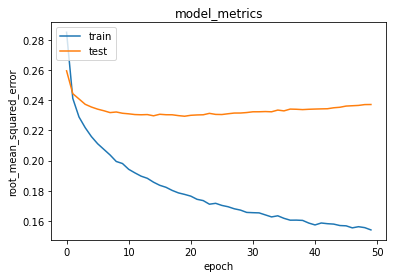

In [67]:
# Visualisasi RMSE
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Hasilnya nilai error akhir sebesar sekitar 0.15 dan error pada data validasi sebesar 0.24. 

### Mendapatkan Rekomendasi

Untuk mendapatkan rekomendasi film, pertama kita ambil sampel user secara acak dan definisikan variabel movie_not_watched yang merupakan daftar film yang belum pernah ditonton oleh pengguna

In [69]:
movie_df = movie_new
df = pd.read_csv('/tmp/ratings.csv')
df = df.iloc[:10000,:]

user_id = df.userId.sample(1).iloc[0]
movie_watched_by_user = df[df.userId == user_id]

movie_not_watched = movie_df[~movie_df['id'].isin(movie_watched_by_user.movieId.values)]['id'] 
movie_not_watched = list(
    set(movie_not_watched)
    .intersection(set(movie_to_movie_encoded.keys())))
 
movie_not_watched = [[movie_to_movie_encoded.get(x)] for x in movie_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched))

In [70]:
# Memperoleh rekomendasi film menggunakan fungsi model.predict() dari library Keras
ratings = model.predict(user_movie_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_watched[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('movie with high ratings from user')
print('----' * 8)
 
top_movie_user = (
    movie_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)
 
movie_df_rows = movie_df[movie_df['id'].isin(top_movie_user)]
for row in movie_df_rows.itertuples():
    print(row.movie_name, ':', row.genre)
 
print('----' * 8)
print('Top 10 movie recommendation')
print('----' * 8)
 
recommended_movie = movie_df[movie_df['id'].isin(recommended_movie_ids)]
for row in recommended_movie.itertuples():
    print(row.movie_name, ':', row.genre)

38/38 [==============================] - 0s 2ms/step
Showing recommendations for users: 39
movie with high ratings from user
--------------------------------
L.A. Confidential (1997) : Crime|Film-Noir|Mystery|Thriller
Chasing Amy (1997) : Comedy|Drama|Romance
--------------------------------
Top 10 movie recommendation
--------------------------------
Winnie the Pooh and the Blustery Day (1968) : Animation|Children|Musical
Seventh Seal, The (Sjunde inseglet, Det) (1957) : Drama
Deer Hunter, The (1978) : Drama|War
Koyaanisqatsi (a.k.a. Koyaanisqatsi: Life Out of Balance) (1983) : Documentary
City Lights (1931) : Comedy|Drama|Romance
Man on Fire (2004) : Action|Crime|Drama|Mystery|Thriller
Old Boy (2003) : Mystery|Thriller
Death Proof (2007) : Action|Adventure|Crime|Horror|Thriller
Interstellar (2014) : Sci-Fi|IMAX
Inside Out (2015) : Animation|Children|Comedy
